In [1]:
import os
from pathlib import Path

import humanfriendly
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import get_cmap
import numpy as np
from meebits_analysis import OMEGAS

In [3]:
dfs = []

benchmark_dir = Path("benchmark")

for omega in OMEGAS:
    for algorithm in ("2scent", "dscent"):
        run_dfs = []
        for path in benchmark_dir.glob(f"{algorithm}_{omega}_*.csv"):
            run_df = pd.read_csv(path)
            run_df["time_seconds"] -= run_df["time_seconds"].min()
            run_df.set_index("time_seconds", inplace=True)
            run_dfs.append(run_df)
        time_seconds = np.arange(
            0, round(np.mean([run_df.index.max() for run_df in run_dfs]), 1), 0.1
        )
        for i, run_df in enumerate(run_dfs):
            run_df = run_df.reindex(run_df.index.union(time_seconds))
            run_df = run_df.interpolate(method="values", limit_direction="both").loc[time_seconds]
            run_dfs[i] = run_df
        if run_dfs:
            median_df = pd.concat(run_dfs).groupby(level=0).mean()
            median_df["omega"] = omega
            median_df["algorithm"] = algorithm
            dfs.append(median_df)

benchmark_df = pd.concat(dfs)

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np
import humanfriendly  # ensure this is imported


def plot_benchmark(benchmark_df, feature_series, feature_desc="", feature_unit=""):
    plot_df = benchmark_df[["algorithm", "omega"]].copy()
    feature_col = feature_series.name
    plot_df[feature_col] = feature_series
    # Prepare subplots — one for each algorithm
    fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

    # Adjust layout to make space for the colorbar
    fig.subplots_adjust(bottom=0.25)

    # Collect all unique omega values across algorithms
    all_omega_values = sorted(benchmark_df["omega"].unique())
    num_omegas = len(all_omega_values)

    # Define a function to truncate a colormap
    def truncate_colormap(cmap, minval=0.3, maxval=1.0, n=256):
        new_cmap = mcolors.LinearSegmentedColormap.from_list(
            f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
            cmap(np.linspace(minval, maxval, n))
        )
        return new_cmap

    # Normalize and color mapping
    norm = mcolors.Normalize(vmin=0, vmax=num_omegas - 1)
    blues_trunc = truncate_colormap(plt.get_cmap("Blues"), minval=0.3)
    scalar_map = cm.ScalarMappable(norm=norm, cmap=blues_trunc)

    # Plot each algorithm
    for i, (algorithm, algorithm_df) in enumerate(benchmark_df.groupby("algorithm")):
        ax = axes[i]

        for j, (omega, omega_df) in enumerate(algorithm_df.groupby("omega")):
            omega_index = all_omega_values.index(omega)
            intensity_color = scalar_map.to_rgba(omega_index)
            ax.plot(
                omega_df.index,
                omega_df[feature_col],
                color=intensity_color,
            )
        ax.set_title(f"{feature_desc}: {algorithm}")
        ax.set_xlabel("Seconds")

    axes[0].set_ylabel(feature_unit)

    # Add colorbar in the space below plots
    cbar_ax = fig.add_axes([0.25, 0.1, 0.5, 0.03])  # [left, bottom, width, height]
    cbar = fig.colorbar(scalar_map, cax=cbar_ax, orientation='horizontal')
    cbar.set_label("ω value")
    cbar.set_ticks(range(num_omegas))
    cbar.set_ticklabels([f"ω = {humanfriendly.format_timespan(v)}" for v in all_omega_values])
    cbar.ax.tick_params(labelrotation=45)

    plt.show()

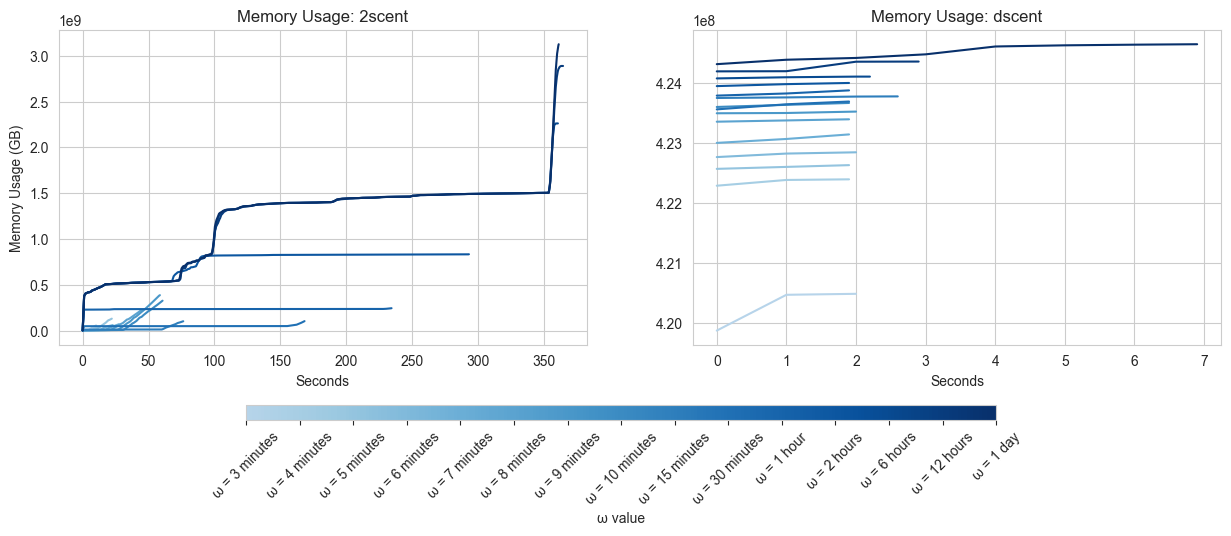

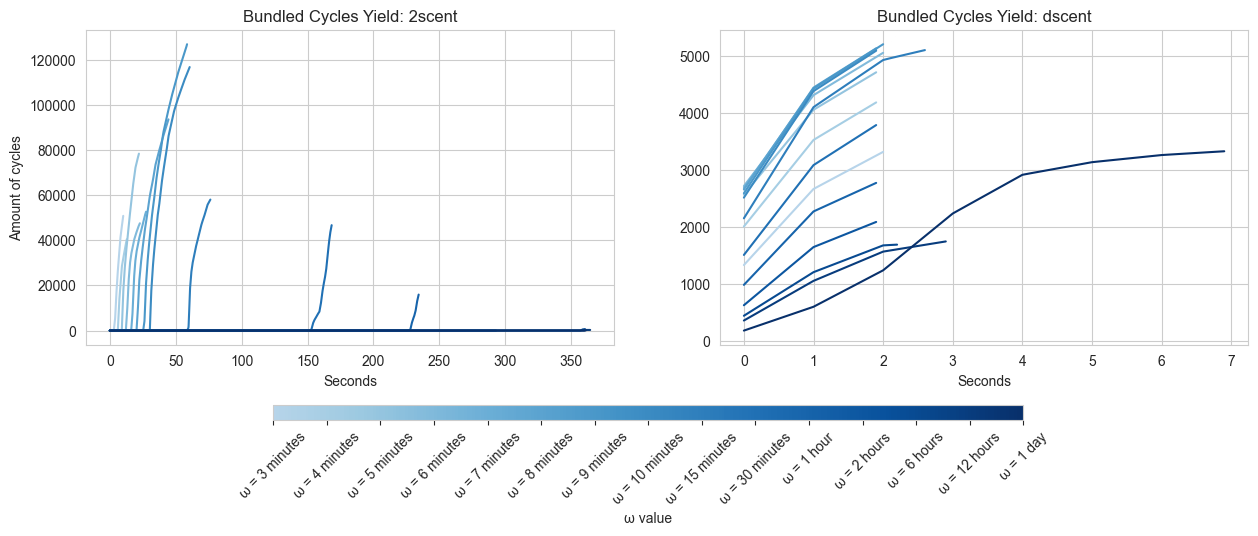

In [5]:
feature_metas = {
    "Memory Usage": dict(
        feature_series=benchmark_df["memory_usage_bytes"] / 1_000_000_000,
        feature_unit="Memory Usage (GB)"
    ),
    "Bundled Cycles Yield": dict(
        feature_series=benchmark_df["cycles_total"],
        feature_unit="Amount of cycles",
    )
}

for feature_desc, feature_meta in feature_metas.items():
    plot_benchmark(benchmark_df, feature_desc=feature_desc, **feature_meta)